# Developing an Age Detector by Photo

# Contents <a id='back'></a>
* [1. Introduction](#intro)
* [2. Initialisation](#init)
* [3. Data Exploration](#data_exploration)
* [4. Exploratory Data Analysis (EDA)](#eda)
    * [4.1 Findings](#findings)
* [5. Modeling](#modeling)
* [6. Preparing the Script to Run on the GPU Platform](#gpu)
    * [6.1 Output](#output)
    * [6.2 Model Evaluation](#model_eval)
* [7. General Conclusion](#conclusion)

## 1. Introduction <a id='intro'></a>

The supermarket chain Good Seed would like to explore whether data science can help them adhere to alcohol laws by making sure they do not sell alcohol to people underage. The shops are equipped with cameras in the checkout area which are triggered when a person is buying alcohol.

### 1.1 Purpose

The primary goal of this project is to develop a model using computer vision methods to verify the age of individuals during the checkout process. The model performance will be assessed based on the mean absolute error (MAE) score. **The model should have a MAE score less than 8.**

[Back to Contents](#back)

## 2. Initialisation <a id='init'></a>

In [1]:
import pandas as pd
import numpy as np
import inspect

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, GlobalMaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau

print('Setup Completed')

Setup Completed


## 3. Data Exploration <a id='data_exploration'></a>

To start working on the task, we have a set of photographs of people with their ages indicated.

The dataset is stored in the `/datasets/faces/` folder, there we can find
- The `final_files` folder with 7.6k photos
- The `labels.csv` file with labels, with two columns: `file_name` and `real_age`

In [2]:
# Load the dataset
df_labels = pd.read_csv('/datasets/faces/labels.csv')

In [3]:
# Check the first five rows
df_labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [4]:
# Check for missing values
df_labels.isna().sum()

file_name    0
real_age     0
dtype: int64

In [5]:
# Check for duplicates
df_labels.duplicated().sum()

0

No missing value or duplicate.

In [6]:
# Check the shape
df_labels.shape

(7591, 2)

The dataset have 7591 people face images of various ages.

In [7]:
# Load the images with a generator
datagen = ImageDataGenerator(rescale=1./255, shear_range=5)

datagen_flow = datagen.flow_from_dataframe(
    dataframe=df_labels,
    directory='/datasets/faces/final_files/',
    x_col='file_name',
    y_col='real_age',
    target_size=(224, 224),
    class_mode='raw',
    batch_size=32,
    seed=42
)

print('All the 7591 images have been loaded successfully')

Found 7591 validated image filenames.
All the 7591 images have been loaded successfully


In [8]:
# Statistical summary of age
df_labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


The ages range from 1 to 100 years old. The mean age of 31.2 is slightly higher than the median age of 29.0 implying that the distribution of ages is slightly skew to the right.

[Back to Contents](#back)

## 4. Exploratory Data Analysis (EDA) <a id='eda'></a>

First, let's plot a histogram to visualise the age distribution.

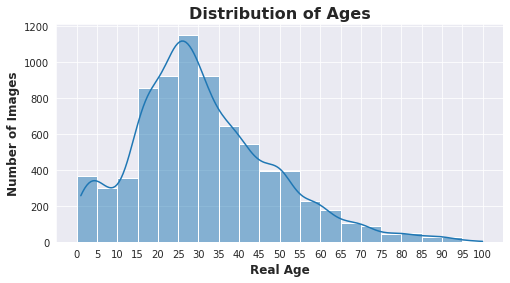

In [9]:
# Plot a histogram to show the age distribution.
sns.set_style('darkgrid')
plt.figure(figsize=(8, 4))

sns.histplot(df_labels['real_age'], bins=np.arange(0, 101, 5), kde=True)
plt.xlabel('Real Age', fontsize=12, fontweight='bold')
plt.ylabel('Number of Images', fontsize=12, fontweight='bold')
plt.xticks(np.arange(0, 101, 5), np.arange(0, 101, 5))
plt.title('Distribution of Ages', fontsize=16, fontweight='bold')
plt.show()

In [10]:
# Calculate the percentages of various age ranges
age_below_15_perc = len(df_labels.query('real_age < 15')) / len(df_labels)
age_15_to_35_perc = len(df_labels.query('15 <= real_age <= 35')) / len(df_labels)
age_above_35_perc = 1. - age_below_15_perc - age_15_to_35_perc

print(f'Below 15 years old: {age_below_15_perc:.2%}')
print(f'Between 15 and 35 years old: {age_15_to_35_perc:.2%}')
print(f'45 years old and above: {age_above_35_perc:.2%}')

Below 15 years old: 13.42%
Between 15 and 35 years old: 52.68%
45 years old and above: 33.90%


About half (52.68%) of the face images are from people of ages between 15 and 35 years old. Let's have a look at some random images.

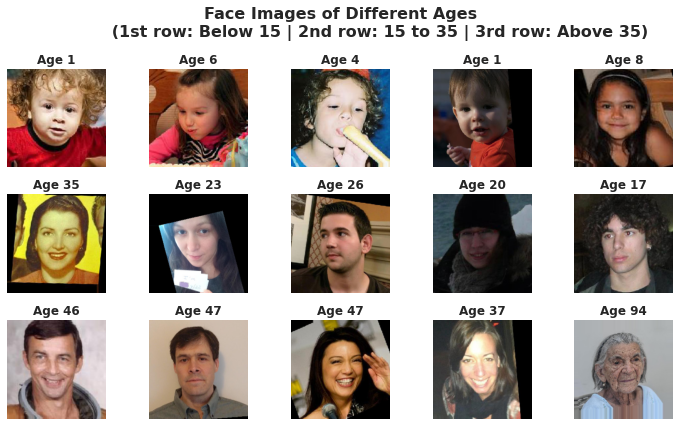

In [11]:
# Rerun this cell to get the images from different batches
# Get the images and label
images, labels = next(datagen_flow)

# Divide the images into different age ranges
below_15_indices = np.where(labels < 15)[0]
between_15_to_35_indices = np.where((labels >= 15) & (labels <= 35))[0]
above_35_indices = np.where(labels > 35)[0]
age_indices = [below_15_indices, between_15_to_35_indices, above_35_indices]

# Set up the figure
sns.set_style('white')
fig, axs = plt.subplots(3, 5, figsize=(10, 6))
fig.suptitle('Face Images of Different Ages\n \
             (1st row: Below 15 | 2nd row: 15 to 35 | 3rd row: Above 35)',
             fontsize=16, fontweight='bold')

# Each row for each age range
for i, age_range in enumerate(age_indices):
    for j in range(5):
        ax = axs[i][j]
        ax.axis(False)
        try:
            idx = age_indices[i][j]    
            ax.imshow(images[idx])
            ax.set_title(f'Age {labels[idx]}', fontweight='bold')
        except IndexError:
            pass
        
fig.tight_layout()
plt.show()

After a few reruns with the above code, it seems like most of the images were correctly labelled except. However, there are still some exceptions which might have wrong labels. (For instances, in the fifth run of the code, it is hard for our human eyes to believe that the two girls in the first rows are less than 15 years old!)

### 4.1 Findings <a id='findings'></a>

The goal of this project is to build a model to verify people's age and identify underages (people of ages around 18-20 years old, the legal definition varies from country to country). Therefore, with about half (52.68%) of the images are of people with ages between 15 and 35, we can build a model which is capable of distinguishing faces between teenagers (13-19 years old) and young adult (20-29 years old).

The dataset provides a good variety of training examples with the following characteristics:
- Existence of black/white and color images.
- Images are of different brightness intensities and backgrounds.
- Images are comprised of different genders and races (but the proportion is unknown).

However, almost all the faces are centred in the images, which might not the cases for cameras in the checkout areas. Therefore, we can consider some data augmentation methods like horizontal flip, rotation, zoom and etc.

[Back to Contents](#back)

## 5. Modeling <a id='modeling'></a>

In this project, the age detecting model will be build based on the transfer learning approach. The chosen base model will be the `ResNet50` which was originally built for a image classification task. The pretrained `ResNet50` model has learned rich image feature representation and therefore is suitable for an age detection task based on face images.

To adapt the model for a regression task, the top layers will be removed. The output layers will consist of one neuron with `relu` as the activation function since ages are positive numbers. In between the base model and the output layers, different combinations of `GlobalAveragePooling2D`, `GlobalMaxPooling2D`, `Dense` and `Dropout` layers will be experimented with. Besides that, suitable learning rates will tuned for the model. L1 and L2 regularisations will also be apllied if needed.

Data augmentation is another important element in transfer learning especially for image-related tasks, we will apply horizontal flip, rotation, zoom and shear on the training images. With 7591 images in the dataset, the images will be split into 80:20 for training and testing. With 6073 training examples of good quality, the model will be tuned by retraining all the parameters.
 
Since the training of a neural network on a image-related task is computational expensive, the model training will be performed on a GPU platform.

In [12]:
def load_train(path):
    '''
    Loads the train part of dataset from the given path
    '''      
    train_gen = ImageDataGenerator(validation_split=0.2,
                                   rescale=1./255,
                                   horizontal_flip=True,
                                   rotation_range=20,
                                   zoom_range=0.2,
                                   shear_range=0.2)
    
    df_labels = pd.read_csv(path + 'labels.csv')
    directory = path + 'final_files'

    train_gen_flow = train_gen.flow_from_dataframe(
        dataframe=df_labels,
        directory=directory,
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=42
    )

    return train_gen_flow

In [13]:
def load_test(path):
    
    '''
    Loads the validation/test part of dataset from the given path
    '''
    test_gen = ImageDataGenerator(validation_split=0.2, 
                                  rescale=1./255)
    
    df_labels = pd.read_csv(path + 'labels.csv')
    directory = path + 'final_files'
    
    test_gen_flow = test_gen.flow_from_dataframe(
        dataframe=df_labels,
        directory=directory,
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=42
    )

    return test_gen_flow

In [14]:
def create_model(input_shape):
    
    '''
    Returns a defined model
    '''
    # Get the base model - ResNet50
    base_model = ResNet50(
        input_shape=input_shape, weights='imagenet', include_top=False
    )    
    
    # Create the model
    model = Sequential()
    model.add(base_model)
    model.add(GlobalAveragePooling2D())
    # model.add(GlobalMaxPooling2D())
    model.add(Dropout(0.3))
    # model.add(Dense(256, activation='relu'))    
    model.add(Dense(1, activation='relu', kernel_regularizer=L1L2(l1=1, l2=1)))
    
    model.compile(loss='mse', 
                  optimizer=Adam(learning_rate=0.0005), 
                  metrics=['mae'])

    return model

In [15]:
def train_model(model,
                train_data,
                test_data,
                batch_size=None,
                epochs=35, 
                steps_per_epoch=None,
                validation_steps=None):
    '''
    Trains and returns the model with the given parameters
    '''
    # Calculate the steps for training and validation if not provided
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    # Self define a learning rate decay function
    # def lr_schedule(epoch):
    #     if epoch < 10:
    #         return 0.0003
    #     else:
    #         return 0.0001
    # lr_callback = LearningRateScheduler(lr_schedule)
    
    # Apply the ReduceLROnPlateau function
    reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                  factor=0.4,
                                  patience=2,
                                  verbose=1)
    
    # Train the model
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              callbacks=[reduce_lr],
              verbose=2)

    return model

[Back to Contents](#back)

## 6. Preparing the Script to Run on the GPU Platform <a id='gpu'></a>

The next cell will generate the python script to run on the GPU platform. 

In [16]:
# prepare a script to run on the GPU platform
init_str = """
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, GlobalMaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau
"""

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

### 6.1 Output <a id='output'></a>

The following is the output from the GPU platform.

Found 6073 validated image filenames.  
Found 1518 validated image filenames.

Train for 190 steps, validate for 48 steps

Epoch 1/35  
190/190 - 120s - loss: 220.4390 - mae: 10.9097 - val_loss: 443.5822 - val_mae: 15.7552  
Epoch 2/35  
190/190 - 98s - loss: 141.5428 - mae: 8.8893 - val_loss: 362.7714 - val_mae: 14.0639  
Epoch 3/35  
190/190 - 99s - loss: 125.0043 - mae: 8.3223 - val_loss: 334.7788 - val_mae: 13.4546  
Epoch 4/35  
190/190 - 96s - loss: 121.9639 - mae: 8.2839 - val_loss: 218.5554 - val_mae: 10.8247  
Epoch 5/35  
190/190 - 96s - loss: 106.8879 - mae: 7.6958 - val_loss: 107.4853 - val_mae: 7.8950  
Epoch 6/35  
190/190 - 96s - loss: 99.3976 - mae: 7.4144 - val_loss: 123.3854 - val_mae: 8.4217  
Epoch 7/35  

Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.  
190/190 - 96s - loss: 93.6474 - mae: 7.1968 - val_loss: 141.3194 - val_mae: 8.5323  
Epoch 8/35  
190/190 - 98s - loss: 69.9776 - mae: 6.1807 - val_loss: 68.6252 - val_mae: 6.0919  
Epoch 9/35  
190/190 - 98s - loss: 61.2581 - mae: 5.7710 - val_loss: 69.9008 - val_mae: 6.0953  
Epoch 10/35  

Epoch 00010: ReduceLROnPlateau reducing learning rate to 8.000000379979611e-05.  
190/190 - 98s - loss: 56.9384 - mae: 5.5940 - val_loss: 80.7092 - val_mae: 6.3393  
Epoch 11/35  
190/190 - 98s - loss: 48.2881 - mae: 5.1762 - val_loss: 66.5796 - val_mae: 5.7658  
Epoch 12/35  
190/190 - 99s - loss: 45.4866 - mae: 4.9725 - val_loss: 65.3699 - val_mae: 5.8171  
Epoch 13/35  
190/190 - 96s - loss: 41.7854 - mae: 4.7237 - val_loss: 65.0168 - val_mae: 5.7283  
Epoch 14/35  
190/190 - 96s - loss: 38.8709 - mae: 4.5952 - val_loss: 65.4882 - val_mae: 5.6921  
Epoch 15/35  

Epoch 00015: ReduceLROnPlateau reducing learning rate to 3.200000210199505e-05.  
190/190 - 96s - loss: 38.1754 - mae: 4.5146 - val_loss: 66.9187 - val_mae: 5.9102  
Epoch 16/35  
190/190 - 96s - loss: 34.3967 - mae: 4.2684 - val_loss: 61.8826 - val_mae: 5.4991  
Epoch 17/35  
190/190 - 95s - loss: 31.6461 - mae: 4.0791 - val_loss: 61.1281 - val_mae: 5.4712  
Epoch 18/35  
190/190 - 97s - loss: 31.2478 - mae: 4.0452 - val_loss: 63.0894 - val_mae: 5.6478  
Epoch 19/35  

Epoch 00019: ReduceLROnPlateau reducing learning rate to 1.280000142287463e-05.  
190/190 - 98s - loss: 29.3869 - mae: 3.9117 - val_loss: 65.1415 - val_mae: 5.7287  
Epoch 20/35  
190/190 - 97s - loss: 29.1768 - mae: 3.8987 - val_loss: 61.1094 - val_mae: 5.4949  
Epoch 21/35  
190/190 - 96s - loss: 28.5863 - mae: 3.8255 - val_loss: 61.0169 - val_mae: 5.4887  
Epoch 22/35  
190/190 - 99s - loss: 26.7132 - mae: 3.7124 - val_loss: 60.6410 - val_mae: 5.4687  
Epoch 23/35  
190/190 - 98s - loss: 26.1191 - mae: 3.6550 - val_loss: 61.5135 - val_mae: 5.5339  
Epoch 24/35  

Epoch 00024: ReduceLROnPlateau reducing learning rate to 5.1200004236306995e-06.  
190/190 - 96s - loss: 26.3708 - mae: 3.6684 - val_loss: 60.9913 - val_mae: 5.4960  
Epoch 25/35  
190/190 - 96s - loss: 25.6524 - mae: 3.6262 - val_loss: 60.6327 - val_mae: 5.4680  
Epoch 26/35  
190/190 - 95s - loss: 24.8983 - mae: 3.5613 - val_loss: 61.0608 - val_mae: 5.5006  
Epoch 27/35  

Epoch 00027: ReduceLROnPlateau reducing learning rate to 2.04800016945228e-06.  
190/190 - 96s - loss: 24.5012 - mae: 3.5382 - val_loss: 61.1283 - val_mae: 5.5050  
Epoch 28/35  
190/190 - 98s - loss: 24.3190 - mae: 3.5171 - val_loss: 60.7452 - val_mae: 5.4713  
Epoch 29/35  

Epoch 00029: ReduceLROnPlateau reducing learning rate to 8.192000677809119e-07.  
190/190 - 98s - loss: 24.5878 - mae: 3.5315 - val_loss: 60.8799 - val_mae: 5.4920  
Epoch 30/35  
190/190 - 98s - loss: 24.7626 - mae: 3.5289 - val_loss: 60.7852 - val_mae: 5.4795  
Epoch 31/35  

Epoch 00031: ReduceLROnPlateau reducing learning rate to 3.2768002711236477e-07.  
190/190 - 98s - loss: 24.6583 - mae: 3.5453 - val_loss: 60.8764 - val_mae: 5.4816  
Epoch 32/35  
190/190 - 99s - loss: 24.4329 - mae: 3.5390 - val_loss: 60.7952 - val_mae: 5.4773  
Epoch 33/35  

Epoch 00033: ReduceLROnPlateau reducing learning rate to 1.3107201084494592e-07.  
190/190 - 98s - loss: 24.3788 - mae: 3.5249 - val_loss: 60.8129 - val_mae: 5.4770  
Epoch 34/35  
190/190 - 98s - loss: 24.4612 - mae: 3.5399 - val_loss: 60.7562 - val_mae: 5.4768  
Epoch 35/35  

Epoch 00035: ReduceLROnPlateau reducing learning rate to 5.242880547484674e-08.  
190/190 - 98s - loss: 24.4820 - mae: 3.5326 - val_loss: 60.6543 - val_mae: 5.4653  

48/48 - 8s - loss: 60.6543 - mae: 5.4653  
Test MAE: 5.4653

[Back to Contents](#back)


### 6.2 Model Evaluation <a id='model_eval'></a>

The following procedure have been carried out to build the final model of this project.

1. Data augmentation on training set
    - Horizontal flip
    - Rotation of 0 to 20 degree
    - Zoom in a ratio of 0.8 to 1.2
    - Shear angle of -0.2 to 0.2 degree


2. Transfer learning from the ResNet50
    - Removing the top layers
    - Apply a global average pooling layer and follow by a dropout layer with rate 0.3.
    - Use one neuron in the output layer with ReLU as the activation function, apply L1 and L2 regularisations of 1 on the parameters.
    

3. Use the adaptive moment estimation (Adam) with an intial learning rate of 0.0005 as the optimiser and apply a learning rate scheduler which multiplies the learning rate by 0.4 if the validation loss does not improve in 2 epochs.

---

**The model has a test MAE of 5.4643 which has met the minimum requirement of 8.** 

Jugding from the final training MAE and validation MAE, the model has an overfitting issue. To reduce the overfitting, we can try the following methods:
- Adjust the data augmentation.
- Adjust regulartisation strengths such as L1 regularisation, L2 regularisation, dropout rate, and etc.
- Collect more images of people with ages below 15 and above 35. Since our model was trained on a dataset with about half of the images from the people with ages 15 to 35 years old, the model may overestimate the people below 15 years old and underestimate the people over 35 years old. 

With a mean absolute error of 5.4653 years old, the model may not perfectly distinguish between an underage and a young adult. However, the model can still issue a warning if a person is suspected to be underaged. On the other hand, the supermarket chain Good Seed could consider building a recommender system tailored to different age groups. This system could display recommeneded items in the checkout area.

[Back to Contents](#back)

## 7. General Conclusion <a id='conclusion'></a>

The dataset have 7591 people face images of various ages. In the exploratory data analysis stage, it has been found out that about half (52.68%) of the images are of people with ages between 15 and 35, these training examples are good to build a model which is capable of distinguishing faces between teenagers (13-19 years old) and young adult (20-29 years old).

The dataset provides a good variety of training examples with the following characteristics:
- Existence of black/white and color images.
- Images are of different brightness intensities and backgrounds.
- Images are comprised of different genders and races (but the proportion is unknown).

The following procedure have been carried out to build the final model of this project.

1. Data augmentation on training set
    - Horizontal flip
    - Rotation of 0 to 20 degree
    - Zoom in a ratio of 0.8 to 1.2
    - Shear angle of -0.2 to 0.2 degree


2. Transfer learning from the ResNet50
    - Removing the top layers
    - Apply a global average pooling layer and follow by a dropout layer with rate 0.3.
    - Use one neuron in the output layer with ReLU as the activation function, apply L1 and L2 regularisations of 1 on the parameters.
    

3. Use the adaptive moment estimation (Adam) with an intial learning rate of 0.0005 as the optimiser and apply a learning rate scheduler which multiplies the learning rate by 0.4 if the validation loss does not improve in 2 epochs.

**The model has a test MAE of 5.4653 which has met the minimum requirement of 8.** 

[Back to Contents](#back)